In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [2]:
files_list = fetch_data(subjects=[0, 1], recording=[1])

Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|#############################################| 48.3M/48.3M [00:00<?, ?B/s]
100%|#####################################| 4.62k/4.62k [00:00<00:00, 4.62MB/s]
100%|#####################################| 51.1M/51.1M [00:00<00:00, 51.1GB/s]
100%|#####################################| 3.90k/3.90k [00:00<00:00, 3.88MB/s]

Download complete in 10m19s (94.8 MB)


In [4]:
files_list

[['C:\\Users\\tiger\\mne_data\\physionet-sleep-data\\SC4001E0-PSG.edf',
  'C:\\Users\\tiger\\mne_data\\physionet-sleep-data\\SC4001EC-Hypnogram.edf'],
 ['C:\\Users\\tiger\\mne_data\\physionet-sleep-data\\SC4011E0-PSG.edf',
  'C:\\Users\\tiger\\mne_data\\physionet-sleep-data\\SC4011EH-Hypnogram.edf']]

In [24]:
raw_train = mne.io.read_raw_edf(files_list[0][0], stim_channel='Event marker', infer_types=True, preload=True)
annot_train = mne.read_annotations(files_list[0][1])
raw_train.set_annotations(annot_train, emit_warning=False)

Extracting EDF parameters from C:\Users\tiger\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~424.6 MB, data loaded>

Using matplotlib as 2D backend.


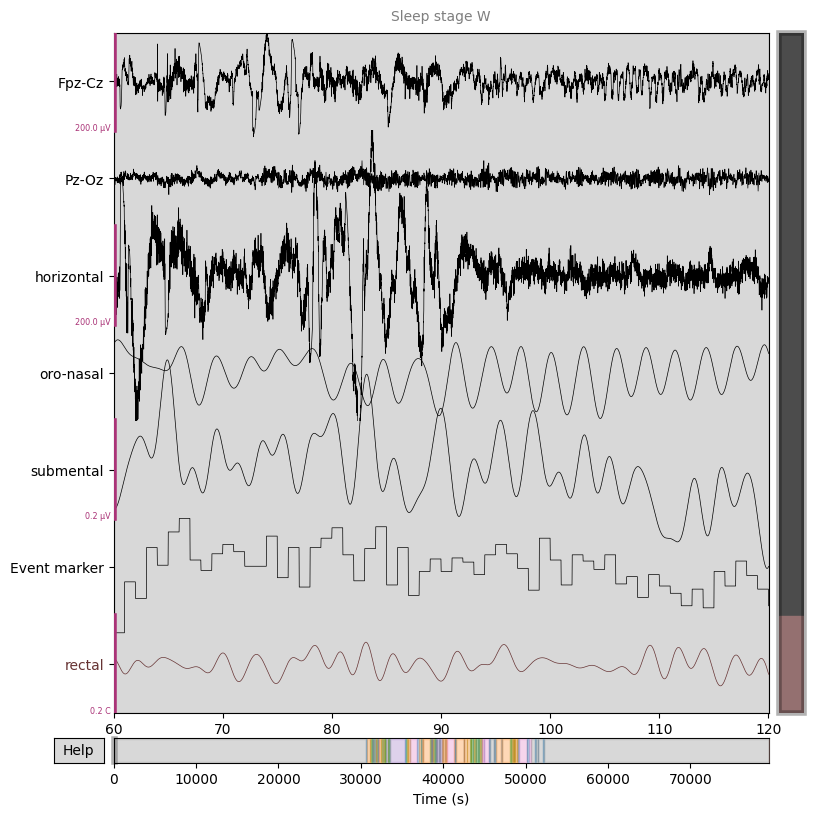

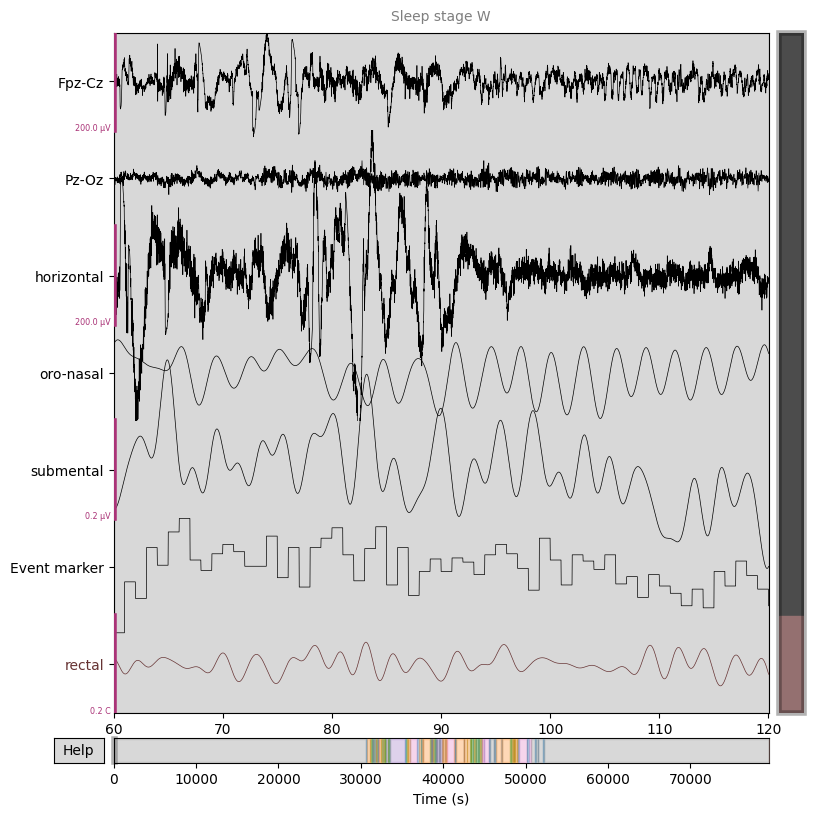

In [6]:
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3,eog=1e-4, emg=1e-7, misc=1e-1))

In [25]:
annotation_desc_2_event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]["onset"] - 30 * 60, annot_train[-2]["onset"] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


In [30]:
events_train

array([[2883000,       0,       1],
       [2886000,       0,       1],
       [2889000,       0,       1],
       ...,
       [5397000,       0,       1],
       [5400000,       0,       1],
       [5403000,       0,       1]])

In [27]:
for i in range(len(events_train)):
    print(events_train[i][0])

2883000
2886000
2889000
2892000
2895000
2898000
2901000
2904000
2907000
2910000
2913000
2916000
2919000
2922000
2925000
2928000
2931000
2934000
2937000
2940000
2943000
2946000
2949000
2952000
2955000
2958000
2961000
2964000
2967000
2970000
2973000
2976000
2979000
2982000
2985000
2988000
2991000
2994000
2997000
3000000
3003000
3006000
3009000
3012000
3015000
3018000
3021000
3024000
3027000
3030000
3033000
3036000
3039000
3042000
3045000
3048000
3051000
3054000
3057000
3060000
3063000
3066000
3069000
3072000
3075000
3078000
3081000
3084000
3087000
3090000
3093000
3096000
3099000
3102000
3105000
3108000
3111000
3114000
3117000
3120000
3123000
3126000
3129000
3132000
3135000
3138000
3141000
3144000
3147000
3150000
3153000
3156000
3159000
3162000
3165000
3168000
3171000
3174000
3177000
3180000
3183000
3186000
3189000
3192000
3195000
3198000
3201000
3204000
3207000
3210000
3213000
3216000
3219000
3222000
3225000
3228000
3231000
3234000
3237000
3240000
3243000
3246000
3249000
3252000
3255000


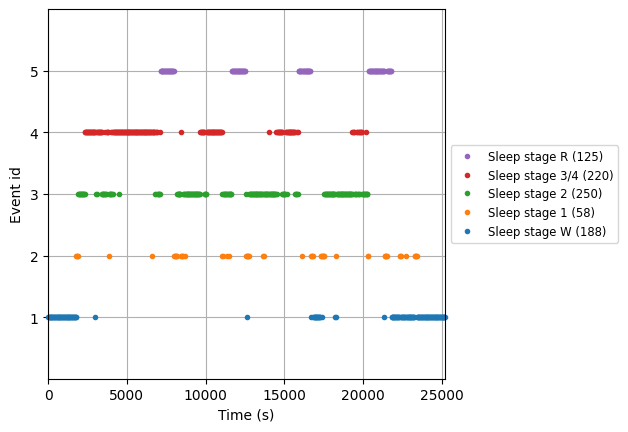

In [8]:
event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3/4": 4,
    "Sleep stage R": 5,
}

fig = mne.viz.plot_events(
    events_train,
    event_id = event_id,
    sfreq=raw_train.info['sfreq'],
    first_samp=events_train[0, 0],
)

In [9]:
tmax = 30 - 1 / raw_train.info['sfreq']

epochs_train =  mne.Epochs(
    raw=raw_train,
    events=events_train,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None
)
del raw_train

print(epochs_train)

Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 – 29.99 s, baseline off, ~13 kB, data not loaded,
 'Sleep stage W': 188
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125>


In [ ]:
raw_test = mne.io.read_raw_edf(
    files_list[1][0], stim_channel="Event marker", infer_types=True, preload=True
)
annot_test = mne.read_annotations(files_list[1][1])
annot_test.crop(annot_test[1]["onset"] - 30 * 60, annot_test[-2]["onset"] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)
epochs_test = mne.Epochs(
    raw=raw_test,
    events=events_test,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
del raw_test

print(epochs_test)

Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1103 events (good & bad), 0 – 29.99 s, baseline off, ~13 kB, data not loaded,
 'Sleep stage W':

Using data from preloaded Raw for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 109 events and 3000 origina

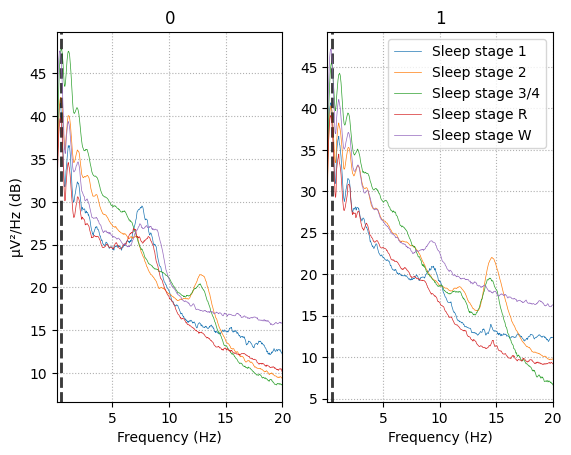

In [ ]:
# keep the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, (ax1, ax2) = plt.subplots(ncols=2)

stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2], ["0", "1"], [epochs_train, epochs_test]):
    for stage, color in zip(stages, stage_colors):
        spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=20.0)
        spectrum.plot(
            ci=None,
            color=color,
            axes=ax,
            show=False,
            average=True,
            spatial_colors=False,
            picks="data",
            exclude="bads",
        )
    ax.set(title=title, xlabel="Frequency (Hz)")
ax1.set(ylabel="µV²/Hz (dB)")
ax2.legend(ax2.lines[2::3], stages)

In [ ]:
spectrum = epochs_train.compute_psd(picks='eeg', fmin=0.5, fmax=30)
psds, freqs = spectrum.get_data(return_freqs=True)

Using data from preloaded Raw for 841 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


Averaging across epochs...


<ipython-input-70-8801dd6f5aeb>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot()


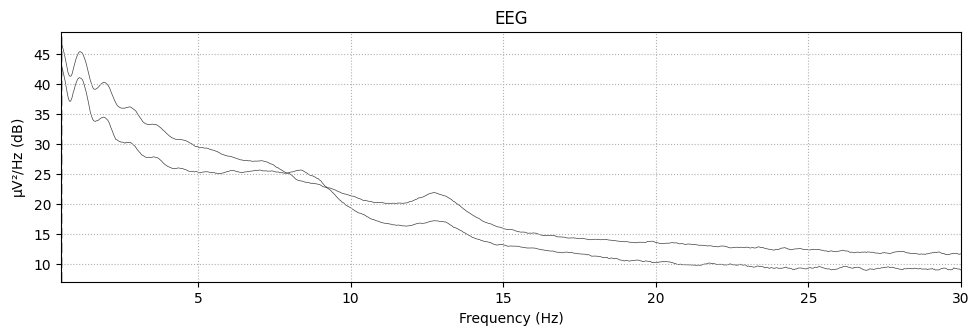

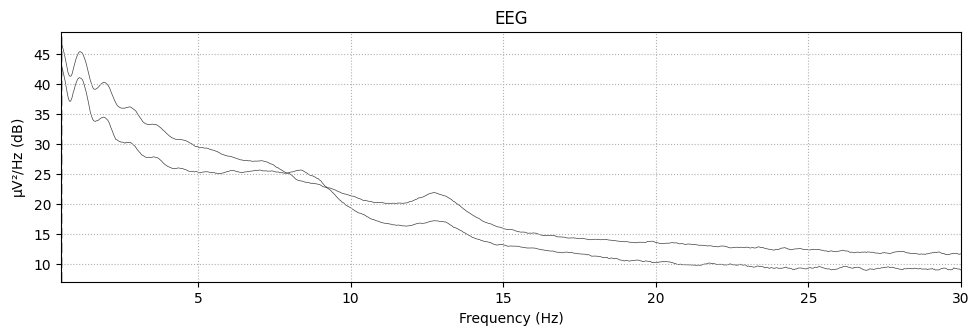

In [ ]:
spectrum.plot()

In [ ]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [ ]:
pipe = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Using data from preloaded Raw for 841 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 1103 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.6854034451495921


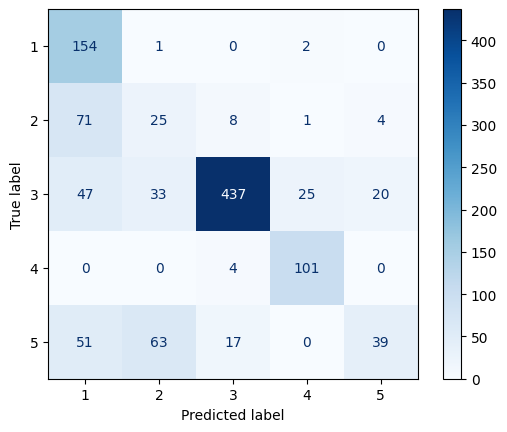

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()

In [ ]:
w_data = epochs_train['Sleep stage W'].get_data()
n1_data = epochs_train['Sleep stage 1'].get_data()

Using data from preloaded Raw for 188 events and 3000 original time points ...
Using data from preloaded Raw for 58 events and 3000 original time points ...


In [ ]:
w_data.shape

(188, 7, 3000)

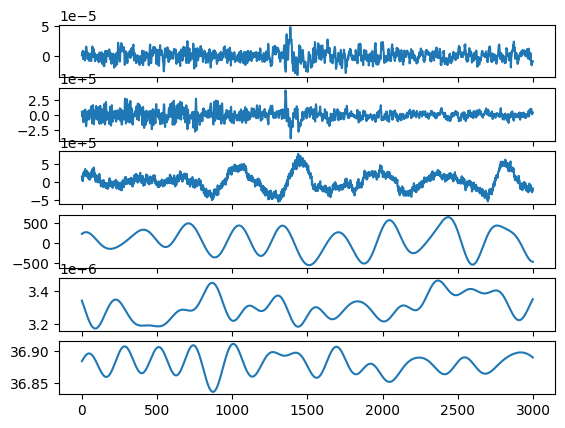

In [ ]:
fig, axs = plt.subplots(6, 1)

for ax in range(len(axs)):
  axs[ax].plot(n1_data[0, ax, :])

plt.show()